# How to obtain completed and blocked per-job metrics

RLlib only lets you record the mean, max, and min of a given episode metric.

Therefore, in order to record the per-job characteristics of all blocked and completed jobs in an episode, we have to log externally to RLlib.

Since RLlib requires we use the internal `trainer.train()` training loop, which internally runs the environment, there is no way for us to externally access environment data other than through RLlib callbacks.

Therefore, there is no way for us to log per-job characteristics inside an RLlib training (or internal evaluation) loop.

Consequently, in order to get the per-job characteristics, we need to use our own evaluation loop. This has been implemented in `ddls.loops.rllib_eval_loop.RLlibEvalLoop` for RLlib agents and `ddls.loops.eval_loop.EvalLoop` for heuristic agents. In order to access per-job characteristics, you must use these loop objects. The best way of doing this for a trained RLlib agent is to store the best checkpoint during training, then test this checkpoint with the script in `scripts/test_rllib_from_config.py` wherethe `test_time_checkpoint_path` variable in the `epoch_loop` config has been set to the RLlib agent's checkpoint path. 

I.e. you will need to test your agent separately from the RLlib training script (and its internal evaluations) in order to get per-job characteristics and use this particular notebook.

In [1]:
%load_ext autoreload
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics_from_wandb_run
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics_from_wandb_sweep
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_wandb_table_from_wandb_run

from ddls.plotting.plotting import PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import copy

from omegaconf import OmegaConf
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-18 07:16:21,742	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.agents.callbacks` has been deprecated. Use `ray.rllib.algorithms.callbacks` instead. This will raise an error in the future!


Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2022-11-18 07:16:24,931	INFO worker.py:1510 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


In [2]:
agent_to_beta_dist_to_run_path = {
    
    'PAC-ML (Ours)': {
        
            '$\\beta_{A}$': 'ong/ddls/285pu693', # TODO: re-run with new GNN architecture
#             # # '$\\beta_{B}$': '',,
            '$\\beta_{B}$': 'ong/ddls/2ivxm24l',
            '$\\beta_{C}$': 'ong/ddls/2iu831df', # TODO: re-run with new GNN architecture
            '$\\beta_{D}$': 'ong/ddls/2i90yp8r', # TODO: re-run with new GNN architecture
        
    },
    
    'Para$_{max}$': {
        
            '$\\beta_{A}$': 'ong/ddls/1eqihpk5',
            '$\\beta_{B}$': 'ong/ddls/3o3b73ki',
            '$\\beta_{C}$': 'ong/ddls/100bnlt4',
            '$\\beta_{D}$': 'ong/ddls/2hsrb7hy',
        
    },
    
    'Para$_{min}$': {
        
            '$\\beta_{A}$': 'ong/ddls/1fg4irzk',
            '$\\beta_{B}$': 'ong/ddls/3jnkna1j',
            '$\\beta_{C}$': 'ong/ddls/sll9w9np',
            '$\\beta_{D}$': 'ong/ddls/2di4ze52',
        
    },
    
    'Random': {
        
            '$\\beta_{A}$': 'ong/ddls/5x12jirn',
            '$\\beta_{B}$': 'ong/ddls/220i9ps7',
            '$\\beta_{C}$': 'ong/ddls/895z9rdc',
            '$\\beta_{D}$': 'ong/ddls/12zievjl',
        
    },
    
}









# agent_to_beta_dist_to_run_path = {
    
#     'PAC-ML (Ours)': {
        
#             # '$\\beta_{A}$': 'ong/ddls/285pu693', # TODO: re-run with new GNN architecture
# #             # # '$\\beta_{B}$': '',,
#             '$\\beta_{B}$': 'ong/ddls/2ivxm24l',
#             # '$\\beta_{C}$': 'ong/ddls/2iu831df', # TODO: re-run with new GNN architecture
#             # '$\\beta_{D}$': 'ong/ddls/2i90yp8r', # TODO: re-run with new GNN architecture
        
#     },
    
# }



In [3]:
%autoreload

# load learner agent run
keys_to_ignore = ['valid/step_stats/'] # for ignoring data not needed for plotting
keys_to_ignore = ['valid/step_stats/', 'valid/episode_stats']
key_substrings_to_remove = ['valid/episode_stats'] # for tidying key strings
key_substrings_to_remove = []
verbose = True

_agent_to_episode_completion_stats_dict, _agent_to_episode_blocked_stats_dict = defaultdict(list), defaultdict(list)
for agent in agent_to_beta_dist_to_run_path.keys():
    # load agent data for each dist
    hue = '$\\beta_{X}$' # grouping by beta dist
    dist_to_run = agent_to_beta_dist_to_run_path[agent]
  
    # load per-job wandb table
    agent_to_wandb_table = load_ramp_cluster_environment_wandb_table_from_wandb_run(dist_to_run, keys_to_ignore=keys_to_ignore, key_substrings_to_remove=key_substrings_to_remove, verbose=verbose)
                    
    # merge learner agent df table artifacts into all learner agents df
    print(f'agent_to_wandb_table keys: {agent_to_wandb_table.keys()}')
    for dist in agent_to_wandb_table.keys():
        for key, val in agent_to_wandb_table[dist].items():
            if 'artifact' in key:
                # load table data
                if 'completed' in key:
                    _dict = _agent_to_episode_completion_stats_dict
                elif 'blocked' in key:
                    _dict = _agent_to_episode_blocked_stats_dict
                else:
                    raise Exception(f'Unable to handle key {key}')
                for k, v in val.items():
                    _dict[k].extend(v)
                # add Agent and hue columns
                _dict['Agent'].extend([agent for _ in range(len(v))])
                _dict[hue].extend([dist for _ in range(len(v))])
            
# remove leading underscore for readability
agent_to_episode_completion_stats_dict, agent_to_episode_blocked_stats_dict = _agent_to_episode_completion_stats_dict, _agent_to_episode_blocked_stats_dict

# convert dicts to dataframes
for key, val in agent_to_episode_completion_stats_dict.items():
    print(f'key {key} -> {len(val)} vals')
agent_episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(agent_episode_completion_stats_df)

for key, val in agent_to_episode_blocked_stats_dict.items():
    print(f'key {key} -> {len(val)} vals')
agent_episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(agent_episode_blocked_stats_df)


Recorded keys: {'_runtime', '_step', '_timestamp'}
Ignored keys: {'valid/step_stats/compute_info_processed', 'valid/episode_stats/demand_dep_info_processed', 'valid/step_stats/mean_demand_compute_throughput', 'valid/episode_stats/jobs_blocked_num_edges', 'valid/episode_stats/num_jobs_blocked', 'valid/step_stats/dep_info_processed', 'valid/episode_stats/jobs_blocked_original_demand_num_edges', 'valid/step_stats/cluster_info_processed', 'valid/step_stats/mean_mounted_worker_utilisation_frac', 'valid/episode_stats/jobs_completed_max_partitions_per_op', 'valid/step_stats/demand_dep_info_processed', 'valid/episode_stats/jobs_completed_max_acceptable_job_completion_time_frac', 'valid/episode_stats/jobs_blocked_total_operation_memory_cost', 'valid/step_stats/step_start_time', 'valid/episode_stats/jobs_completed_total_operation_memory_cost', 'valid/step_stats/flow_info_processed', 'valid/episode_stats/jobs_completed_num_mounted_workers', 'valid/step_stats/mean_num_mounted_workers', 'valid/epi

,jobs_completed_original_demand_num_nodes,job_computation_overhead_time,jobs_completed_mean_mounted_worker_utilisation_frac,jobs_completed_max_acceptable_job_completion_time_frac,jobs_completed_max_acceptable_job_completion_time,jobs_completed_job_sequential_completion_time,jobs_completed_num_mounted_channels,job_completion_time_speedup,job_communication_overhead_time,jobs_completed_original_demand_total_dependency_size,...,jobs_completed_original_demand_num_edges,jobs_completed_num_nodes,jobs_completed_max_partitions_per_op,job_completion_time,jobs_completed_num_mounted_workers,jobs_completed_total_operation_memory_cost,jobs_completed_num_edges,jobs_completed_total_dependency_size,Agent,$\beta_{X}$
0,96,1117.704125,0.019996,0.58,2593.0640,4470.80,12,3.999198,0.383051,1.027801e+09,...,117,198,4,1117.924198,4,2.368447e+09,738,4.742729e+09,PAC-ML (Ours),$\beta_{A}$
1,136,9500.210497,0.019993,0.52,19760.0780,38000.15,12,3.998614,5.182546,2.791009e+10,...,153,478,4,9503.329382,4,2.496262e+10,2433,6.144001e+10,PAC-ML (Ours),$\beta_{A}$
2,96,1117.704125,0.019996,0.52,2324.8160,4470.80,12,3.999198,0.383051,1.027801e+09,...,117,198,4,1117.924198,4,2.368447e+09,738,4.742729e+09,PAC-ML (Ours),$\beta_{A}$
3,96,1117.704125,0.019996,0.79,3531.9320,4470.80,12,3.999198,0.383051,1.027801e+09,...,117,198,4,1117.924198,4,2.368447e+09,738,4.742729e+09,PAC-ML (Ours),$\beta_{A}$
4,136,9500.210497,0.019993,0.39,14820.0585,38000.15,12,3.998614,5.182546,2.791009e+10,...,153,478,4,9503.329382,4,2.496262e+10,2433,6.144001e+10,PAC-ML (Ours),$\beta_{A}$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,82,17262.702604,0.019994,0.86,29691.8010,34525.35,2,1.999414,5.200733,2.946706e+10,...,83,156,2,17267.730385,2,3.062530e+10,372,4.488655e+10,Random,$\beta_{D}$
11060,136,19000.075000,0.019999,0.85,32300.1275,38000.15,2,1.999927,0.864417,2.791009e+10,...,153,250,2,19000.766565,2,2.496262e+10,607,4.218474e+10,Random,$\beta_{D}$
11061,136,9500.210497,0.015994,0.47,17860.0705,38000.15,20,3.998454,5.773305,2.791009e+10,...,153,478,4,9503.711415,5,2.496262e+10,2433,6.144001e+10,Random,$\beta_{D}$
11062,136,4750.105355,0.017765,0.72,27360.1080,38000.15,72,7.994063,5.414261,2.791009e+10,...,153,934,8,4753.546724,9,2.496262e+10,9757,9.995056e+10,Random,$\beta_{D}$


key jobs_blocked_num_edges -> 4936 vals
key jobs_blocked_original_demand_total_dependency_size -> 4936 vals
key jobs_blocked_num_nodes -> 4936 vals
key jobs_blocked_max_acceptable_job_completion_time_frac -> 4936 vals
key jobs_blocked_max_acceptable_job_completion_time -> 4936 vals
key jobs_blocked_total_operation_memory_cost -> 4936 vals
key jobs_blocked_original_demand_num_nodes -> 4936 vals
key jobs_blocked_job_sequential_completion_time -> 4936 vals
key jobs_blocked_original_demand_total_operation_memory_cost -> 4936 vals
key jobs_blocked_total_dependency_size -> 4936 vals
key jobs_blocked_original_demand_num_edges -> 4936 vals
key Agent -> 4936 vals
key $\beta_{X}$ -> 4936 vals


,jobs_blocked_num_edges,jobs_blocked_original_demand_total_dependency_size,jobs_blocked_num_nodes,jobs_blocked_max_acceptable_job_completion_time_frac,jobs_blocked_max_acceptable_job_completion_time,jobs_blocked_total_operation_memory_cost,jobs_blocked_original_demand_num_nodes,jobs_blocked_job_sequential_completion_time,jobs_blocked_original_demand_total_operation_memory_cost,jobs_blocked_total_dependency_size,jobs_blocked_original_demand_num_edges,Agent,$\beta_{X}$
0,159,1.873329e+10,142,0.25,9167.0875,1.725866e+10,142,36668.35,1.725866e+10,1.873329e+10,159,PAC-ML (Ours),$\beta_{A}$
1,83,2.946706e+10,82,0.24,8286.0840,3.062530e+10,82,34525.35,3.062530e+10,2.946706e+10,83,PAC-ML (Ours),$\beta_{A}$
2,83,2.946706e+10,82,0.93,32108.5755,3.062530e+10,82,34525.35,3.062530e+10,2.946706e+10,83,PAC-ML (Ours),$\beta_{A}$
3,47,2.422161e+09,46,0.11,3966.7265,3.046234e+09,46,36061.15,3.046234e+09,2.422161e+09,47,PAC-ML (Ours),$\beta_{A}$
4,117,1.027801e+09,96,0.18,804.7440,2.368447e+09,96,4470.80,2.368447e+09,1.027801e+09,117,PAC-ML (Ours),$\beta_{A}$
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,83,2.946706e+10,82,0.85,29346.5475,3.062530e+10,82,34525.35,3.062530e+10,2.946706e+10,83,Random,$\beta_{D}$
4932,83,2.946706e+10,82,0.71,24512.9985,3.062530e+10,82,34525.35,3.062530e+10,2.946706e+10,83,Random,$\beta_{D}$
4933,153,2.791009e+10,136,0.61,23180.0915,2.496262e+10,136,38000.15,2.496262e+10,2.791009e+10,153,Random,$\beta_{D}$
4934,117,1.027801e+09,96,0.78,3487.2240,2.368447e+09,96,4470.80,2.368447e+09,1.027801e+09,117,Random,$\beta_{D}$


In [4]:
# add JCT speed-up requested column to completion data frame
agent_episode_completion_stats_df['job_completion_time_speedup_requested'] = np.ceil(1 / agent_episode_completion_stats_df['jobs_completed_max_acceptable_job_completion_time_frac'])

# add JCT speed-up excess factor relative to requested JCT speed-up 
agent_episode_completion_stats_df['job_completion_time_speedup_excess'] = agent_episode_completion_stats_df['job_completion_time_speedup'] / agent_episode_completion_stats_df['job_completion_time_speedup_requested']

In [91]:
def scatterplot(df, metric, xaxis, add_line_of_best_fit=False, title=None, ylabel=None, show_xaxis_title=True, show_xaxis=True, show_yaxis_title=True, xaxis_label_style='plain', **kwargs):
    
    aesthetics = PlotAesthetics()
    aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

    scaling_factor = 1
    # scaling_factor = 0.6
    # scaling_factor = 0.4
    width_scaling_factor = 1
    height_scaling_factor = 1
    
    metric_to_label = {
        
        'job_completion_time_speedup': 'Actual JCT Speed-Up',
        'jobs_completed_mean_mounted_worker_utilisation_frac': 'Worker Utilisation',
            
        'job_completion_time_speedup_requested': 'Requested JCT Speed-Up',
        'jobs_completed_num_mounted_workers': '\# Workers',
        
        'original_demand_num_nodes': '\# Ops.',
        'original_demand_num_edges': '\# Deps.',

        'original_demand_total_operation_memory_cost': '$\\Sigma$ Op. Mem.',
        'original_demand_total_dependency_size': '$\\Sigma$ Dep. Size',
        'original_demand_total_size': 'Job Size',

        'job_sequential_completion_time': 'JCT$^{seq}$',
        
    }
        
    hue = 'Agent'
    style = 'Agent'
    
    legend = 'auto'
    # legend = None
    
    # set hue order for colour palette
    hue_order = list(agent_to_beta_dist_to_run_path.keys())
    print(f'hue_order: {hue_order}')
    
    # generate colour for each agent given hue order and colour palette
    _palette = iter(sns.color_palette(aesthetics.palette))
    # _palette = iter(sns.color_palette('pastel'))
    palette = {agent: next(_palette) for agent in hue_order}
    print(palette)
    
    xlog = False
    ylog = False
    
    # if metric in ['jobs_completed_original_demand_num_nodes', 'jobs_blocked_original_demand_num_nodes', 'jobs_completed_original_demand_num_edges', 'jobs_blocked_original_demand_num_edges', 'jobs_completed_max_acceptable_job_completion_time_frac', 'jobs_blocked_max_acceptable_job_completion_time_frac', 'jobs_completed_num_mounted_workers']:
    #     yaxis_label_style = 'plain'
    # else:
    #     yaxis_label_style = 'sci'
    yaxis_label_style = 'plain'
    
    linewidth = 0 # border around scatter points
    
    # marker_size = 10
    marker_size = 20
    
    # marker_alpha = 0.75
    marker_alpha = 0.5
    
        
    
    
    # print(f'Plotting metric {metric} -> min={np.min(df[metric+"_mean"])} | max={np.max(df[metric+"_mean"])} | mean={np.mean(df[metric+"_mean"])}')
    
    if not add_line_of_best_fit:
        f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
        
        g = sns.scatterplot(data=df, 
                         x=xaxis, 
                         y=metric, 
                         hue=hue, 
                         # style=style,
                         legend=legend,
                         palette=palette,
                         linewidth=linewidth,
                         s=marker_size,
                         alpha=marker_alpha,
                        )
        if legend is not None:
            handles, lables = g.get_legend_handles_labels()
            # for h in handles:
            #     h.set_markersize(marker_size)
            ax.legend(loc='upper center', 
                      bbox_to_anchor=(0.5, 1.6), 
                      ncol=4,
                      # ncol=5,
                      labelspacing=0.1, 
                      columnspacing=1, 
                      prop={'size': 10},
                      title=None,
                      frameon=False,
                     )
    else:
        g = sns.lmplot(data=df, 
                         x=xaxis, 
                         y=metric, 
                         hue=hue, 
                         style=style,
                         legend=None,
                         palette=palette,
                         # linewidth=linewidth,
                         # s=marker_size,
                         # alpha=marker_alpha,
                         # height=1,
                        ci=None,
                        **kwargs,
                        )
        ax = plt.gca()
    if xaxis == 'job_completion_time_speedup_requested' and metric == 'job_completion_time_speedup':
        _min, _max = np.min(df[xaxis]), np.max(df[xaxis])
        plt.plot([_min, _max], 
                 [_min, _max],
                 linewidth=aesthetics.linewidth,
                 color='#06c258',
                )
    if ylabel is None:
        if metric in metric_to_label:
            ylabel = metric_to_label[metric]
    if xaxis in metric_to_label:
        xlabel = metric_to_label[xaxis]
    else:
        xlabel = None
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    ax.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
    ax.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    sns.despine(ax=ax) # remove top and right spines
    if xlog:
        ax.set(xscale='log')
    if ylog:
        ax.set(yscale='log')
    if title is not None:
        plt.title(title)
    plt.gcf().patch.set_alpha(0.0)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if not show_xaxis_title:
        ax.xaxis.set_label_text('')
    if not show_xaxis:
        ax.get_xaxis().set_visible(False)
    if not show_yaxis_title:
        ax.yaxis.set_label_text('')
    plt.show()

hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


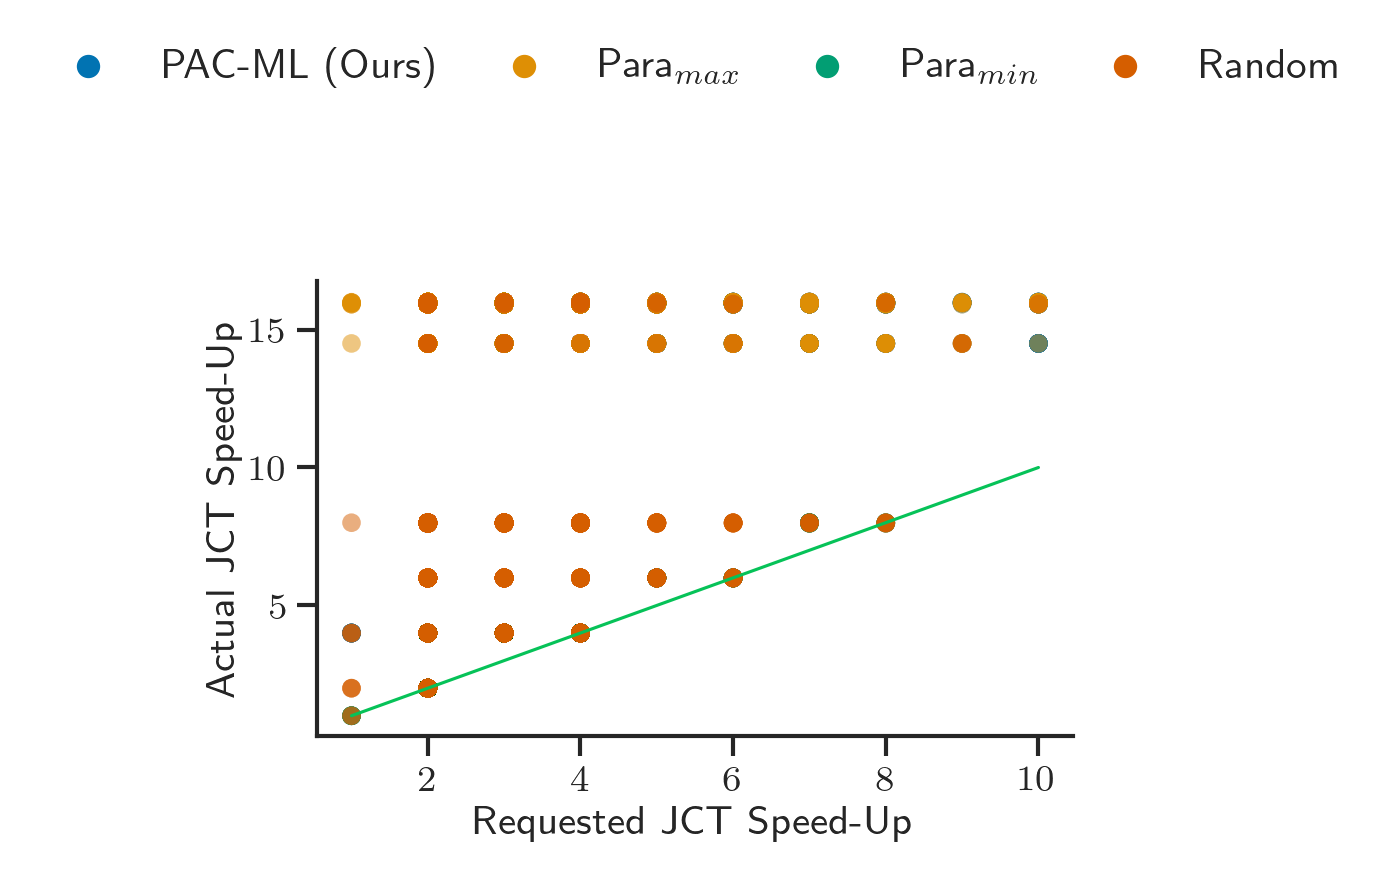

In [92]:
# completion stats
yaxes = ['job_completion_time_speedup']
xaxes = ['job_completion_time_speedup_requested']
for metric in yaxes:
    for xaxis in xaxes:
        scatterplot(df=agent_episode_completion_stats_df, metric=metric, xaxis=xaxis, add_line_of_best_fit=False)

hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


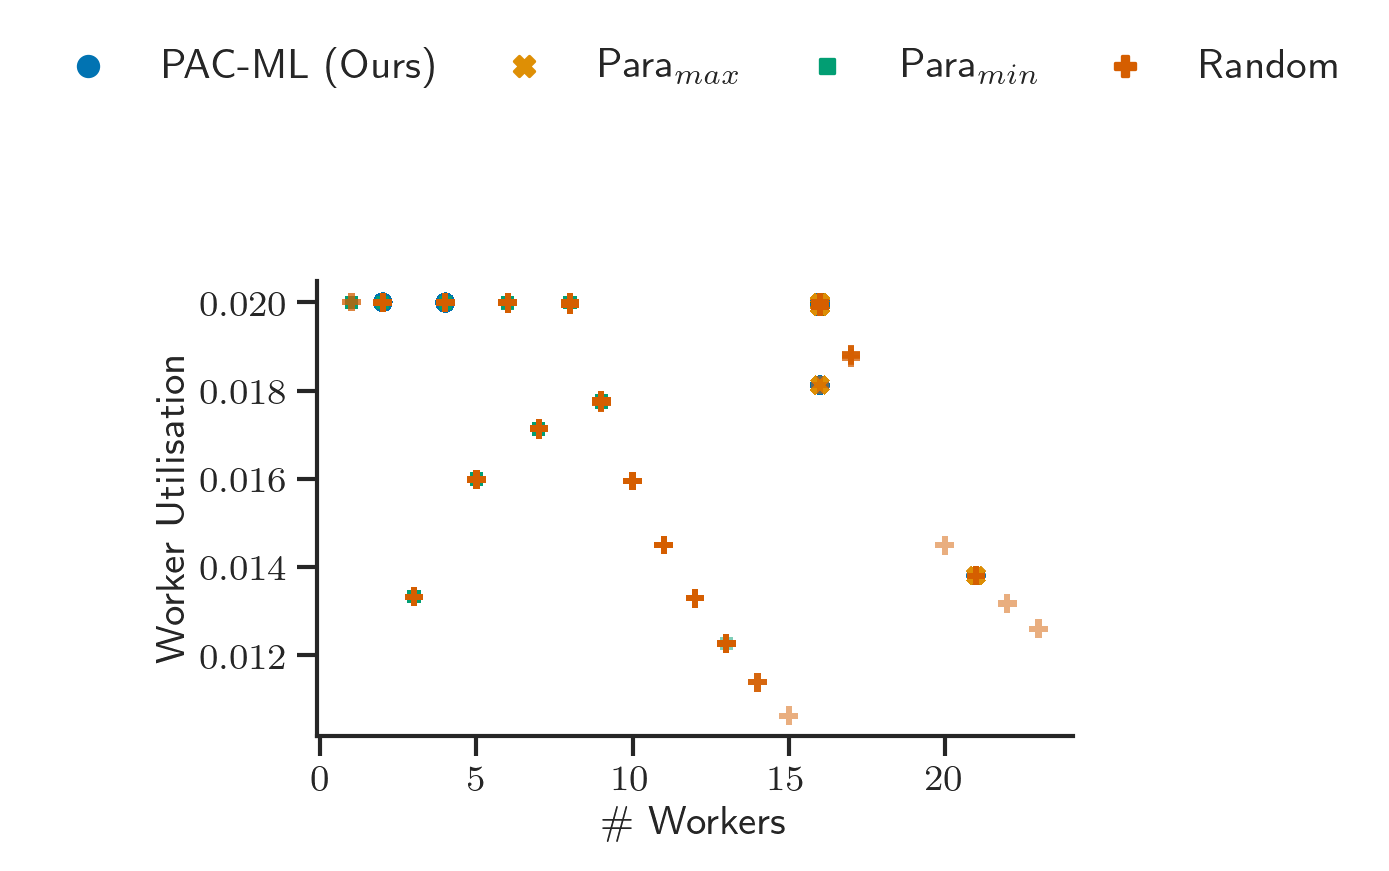

In [7]:
# completion stats
yaxes = ['jobs_completed_mean_mounted_worker_utilisation_frac']
xaxes = ['jobs_completed_num_mounted_workers']
for metric in yaxes:
    for xaxis in xaxes:
        scatterplot(df=agent_episode_completion_stats_df, metric=metric, xaxis=xaxis)

In [58]:
def histplot(df, metric, title=None):
    
    hue = 'Agent'
    
    ylabel = None

    # xaxis_label_style = 'sci' # paper training curve
    xaxis_label_style = 'plain'

    xlog = False
    # xlog = True

    # plot_type = 'cdf'
    plot_type = 'hist'

    if plot_type == 'cdf':
        element = 'step' # bars step
        fill = False # True alse
        cumulative = True
        stat = 'probability' # count probability density
        common_norm = False # True False
        # multiple = 'layer'
    else:
        element = 'bars' # bars step
        fill = True # True alse
        cumulative = False
        stat = 'count' # count probability density
        common_norm = False # True False
        multiple = 'dodge' # layer dodge

    title = None

    legend = 'auto'
    # legend = None

    xlim = None

    ylim = None
    
    if metric == 'job_completion_time_speedup_requested':
        ylog = True
        shrink = 5
    elif metric == 'job_completion_time_speedup_excess':
        ylog = False
        shrink = 2.5
    else:
        ylog = False
        shrink = 1
    if title is not None:
        plt.title(title)

    scaling_factor = 1
    width_scaling_factor = 1
    height_scaling_factor = 1

    aesthetics = PlotAesthetics()
    aesthetics.set_icml_paper_plot_aesthetics()
    
    
    
    
    
    
    
    
    
    print(f'Plotting metric {metric}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.histplot(data=df,
                 x=metric,
                 hue=hue,
#                  hue_order=list(agent_to_path.keys()),
                 element=element,
                 fill=fill,
                 cumulative=cumulative,
                 stat=stat,
                 common_norm=common_norm,
                 multiple=multiple,
                 log_scale=xlog,
                 legend=legend,
                 line_kws={'edgecolor': None},
                 shrink=shrink,
                )
    
#     plt.legend(
# #               loc='upper center',
# #               loc='upper left',
#               # loc='best',
#               bbox_to_anchor=(0.5, 1.2), 
# #               bbox_to_anchor=(0.5, 1.2),
#               labelspacing=0.1,
#               columnspacing=0.2,
#               # ncol=int(len(list(all_job_df_dict.keys()))/n_rows), 
#               prop={'size': legend_font_size},
#     )

    if legend is not None:
        handles, lables = g.get_legend_handles_labels()
        for h in handles:
            h.set_markersize(2)
            h.set_linewidth(aesthetics.linewidth)
        ax.legend(loc='upper center', 
                  bbox_to_anchor=(0.5, 1.4), 
                  ncol=3,
                  # ncol=5,
                  labelspacing=0.1, 
                  columnspacing=4, 
                  prop={'size': 6},
                  title=None,
                  frameon=False,
                 )
    
    g.set_xlabel(metric)
    if ylabel is not None:
        g.set_ylabel(ylabel)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    # ax.xaxis.label.set_size(2)
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    # plt.xlim([None, 10])
    if ylog:
        g.set(yscale='log')
    # g.set(xscale='log')
    if xlog:
        g.set(xscale='log')
        # g.set(xscale='symlog')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting metric job_completion_time_speedup


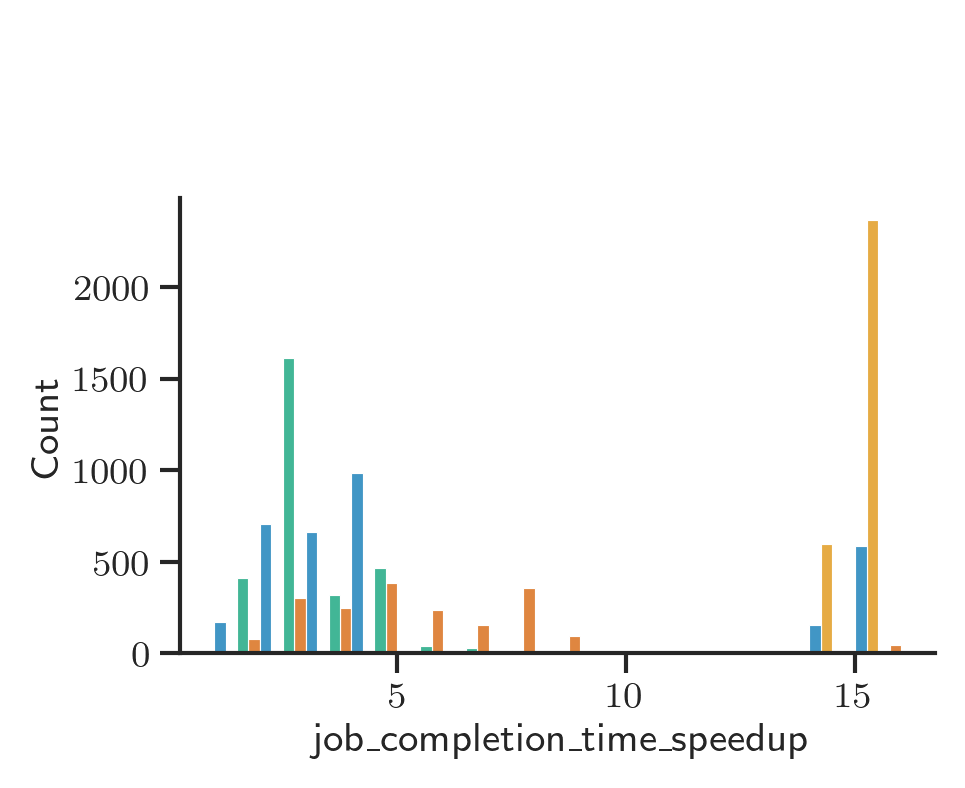

Plotting metric job_completion_time_speedup_requested


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


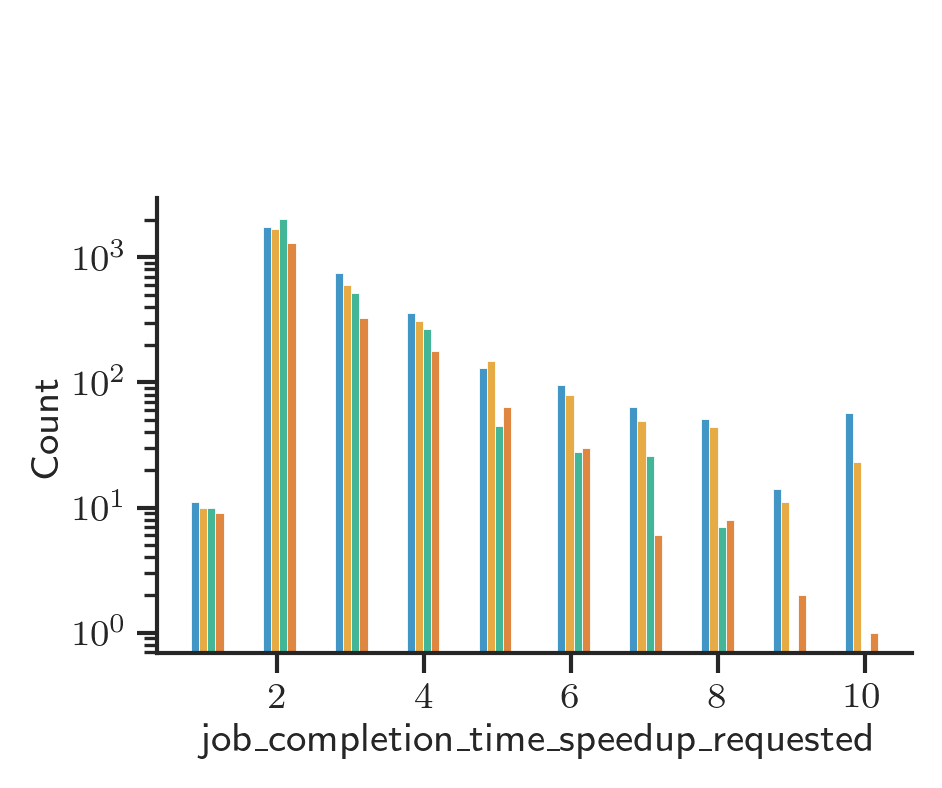

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting metric job_completion_time_speedup_excess


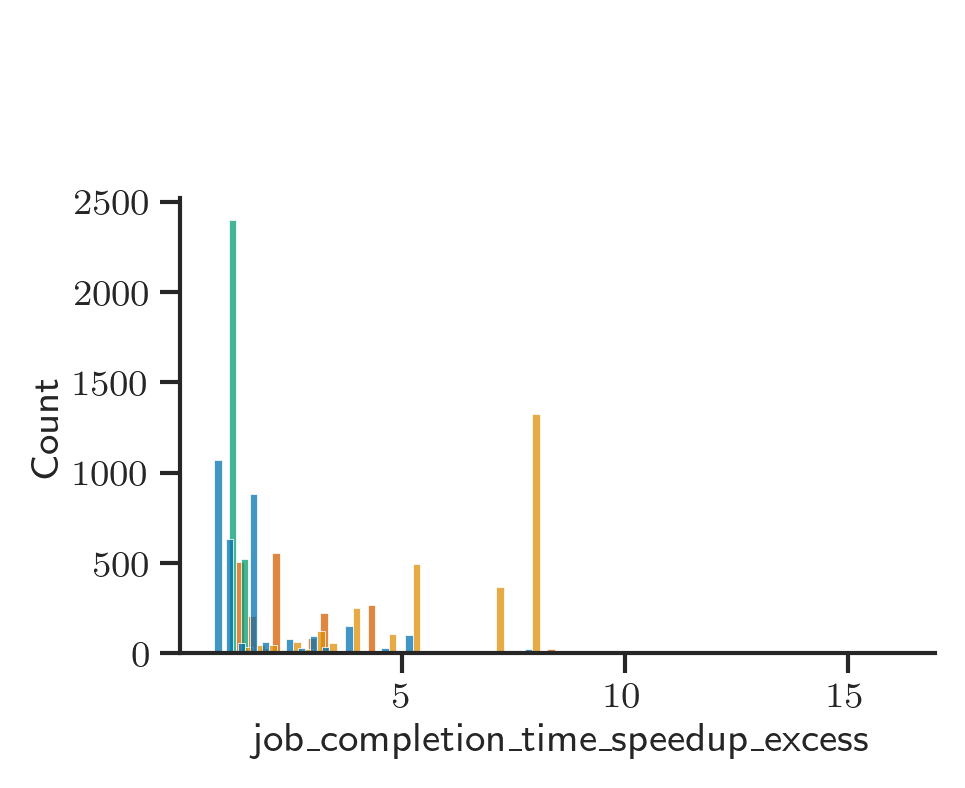

In [9]:
# completion stats
metrics = [
#            'jobs_completed_original_demand_num_nodes', 
#            'jobs_completed_original_demand_num_edges', 
#            'jobs_completed_original_demand_total_operation_memory_cost',
#            'jobs_completed_original_demand_total_dependency_size',
           
#            'jobs_completed_job_sequential_completion_time',
#            'jobs_completed_max_partitions_per_op',
           
#            'jobs_completed_mean_mounted_worker_utilisation_frac',
           
           'job_completion_time_speedup',
           'job_completion_time_speedup_requested',
           'job_completion_time_speedup_excess',
          ]
for metric in metrics:
    histplot(df=agent_episode_completion_stats_df, metric=metric)

# Per-Job Blocking Rate Metrics

In [70]:
# use completed and blocked dataframes to create a blocking rate dataframe for each metric of interest

metrics = [
            'original_demand_num_nodes',
            'original_demand_num_edges',
    
            'original_demand_total_operation_memory_cost',
            'original_demand_total_dependency_size',
            'original_demand_total_size',
    
            'job_sequential_completion_time',
    
        ]

# add total size column by summing deps and ops sizes
agent_episode_completion_stats_df['jobs_completed_original_demand_total_size'] = agent_episode_completion_stats_df['jobs_completed_original_demand_total_operation_memory_cost'] + agent_episode_completion_stats_df['jobs_completed_original_demand_total_dependency_size']
agent_episode_blocked_stats_df['jobs_blocked_original_demand_total_size'] = agent_episode_blocked_stats_df['jobs_blocked_original_demand_total_operation_memory_cost'] + agent_episode_blocked_stats_df['jobs_blocked_original_demand_total_dependency_size']

# round job sequential completion time to remove floating point differences so can easily group on per-job basis
agent_episode_completion_stats_df['jobs_completed_job_sequential_completion_time'] = np.around(agent_episode_completion_stats_df['jobs_completed_job_sequential_completion_time'], decimals=7)
agent_episode_blocked_stats_df['jobs_blocked_job_sequential_completion_time'] = np.around(agent_episode_blocked_stats_df['jobs_blocked_job_sequential_completion_time'], decimals=7)

# group dataframes by agent and beta distribution
agent_completion_grouped_df = agent_episode_completion_stats_df.groupby(['Agent', '$\\beta_{X}$'])
agent_blocked_grouped_df = agent_episode_blocked_stats_df.groupby(['Agent', '$\\beta_{X}$'])

# count number of times each per-job metric occurs in completed and blocked data frames
agent_to_dist_to_metric_to_value_to_completed_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0))))
agent_to_dist_to_metric_to_value_to_blocked_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0))))
for agent in agent_to_beta_dist_to_run_path.keys():
    for metric in metrics:    

        # count metric occurrances in completed df for each agent
        print(f'\nCompleted DataFrame')
        for keys, agent_df in agent_completion_grouped_df:
            _agent, dist = keys
            if _agent == agent:
                print(f'\tAgent: {agent} | Dist: {dist}')
                metric_values, metric_counts = np.unique(agent_df['jobs_completed_' + metric], return_counts=True)
                for metric_value, metric_count in zip(metric_values, metric_counts):
                    print(f'Metric {metric} | Value: {metric_value} | Count: {metric_count}')
                    agent_to_dist_to_metric_to_value_to_completed_counts[agent][dist][metric][metric_value] = metric_count

        # count metric occurrances in blocked df for each agent
        print(f'\nBlocked DataFrame')
        for keys, agent_df in agent_blocked_grouped_df:
            _agent, dist = keys
            if _agent == agent:
                print(f'\tAgent: {agent}')
                metric_values, metric_counts = np.unique(agent_df['jobs_blocked_' + metric], return_counts=True)
                for metric_value, metric_count in zip(metric_values, metric_counts):
                    print(f'Metric {metric} | Value: {metric_value} | Count: {metric_count}')
                    agent_to_dist_to_metric_to_value_to_blocked_counts[agent][dist][metric][metric_value] = metric_count
            
# create blocking rate dataframe
agent_per_job_metric_blocking_rate_df = defaultdict(list)
for agent in agent_to_dist_to_metric_to_value_to_completed_counts.keys():
    for dist in agent_to_dist_to_metric_to_value_to_completed_counts[agent].keys():
        vals_per_metric_at_start_of_loop = len(agent_per_job_metric_blocking_rate_df[metrics[0]])
        for metric in metrics:
            # get all metric values found across completion and blocked data frames
            metric_values = set()
            for df in [agent_to_dist_to_metric_to_value_to_completed_counts, agent_to_dist_to_metric_to_value_to_blocked_counts]:
                for metric_value in df[agent][dist][metric].keys():
                    metric_values.add(metric_value)

            # use counts for metric value to get blocking rate for each metric value
            for metric_value in metric_values:
                metric_value_blocking_rate = agent_to_dist_to_metric_to_value_to_blocked_counts[agent][dist][metric][metric_value] / (agent_to_dist_to_metric_to_value_to_completed_counts[agent][dist][metric][metric_value] + agent_to_dist_to_metric_to_value_to_blocked_counts[agent][dist][metric][metric_value])
                agent_per_job_metric_blocking_rate_df[metric].append(metric_value)
                agent_per_job_metric_blocking_rate_df[metric+'_blocking_rate'].append(metric_value_blocking_rate)

        vals_added_this_loop = int(len(agent_per_job_metric_blocking_rate_df[metrics[0]]) - vals_per_metric_at_start_of_loop)
        for _ in range(vals_added_this_loop):
            agent_per_job_metric_blocking_rate_df['Agent'].append(agent)
            agent_per_job_metric_blocking_rate_df['$\\beta_{X}$'].append(dist)
    
for key, val in agent_per_job_metric_blocking_rate_df.items():
    print(f'key {key} -> {len(val)} vals')
agent_per_job_metric_blocking_rate_df = pd.DataFrame(agent_per_job_metric_blocking_rate_df)
display(agent_per_job_metric_blocking_rate_df)


Completed DataFrame
	Agent: PAC-ML (Ours) | Dist: $\beta_{A}$
Metric original_demand_num_nodes | Value: 46 | Count: 161
Metric original_demand_num_nodes | Value: 82 | Count: 166
Metric original_demand_num_nodes | Value: 96 | Count: 154
Metric original_demand_num_nodes | Value: 136 | Count: 153
Metric original_demand_num_nodes | Value: 142 | Count: 149
	Agent: PAC-ML (Ours) | Dist: $\beta_{B}$
Metric original_demand_num_nodes | Value: 46 | Count: 140
Metric original_demand_num_nodes | Value: 82 | Count: 136
Metric original_demand_num_nodes | Value: 96 | Count: 153
Metric original_demand_num_nodes | Value: 136 | Count: 147
Metric original_demand_num_nodes | Value: 142 | Count: 163
	Agent: PAC-ML (Ours) | Dist: $\beta_{C}$
Metric original_demand_num_nodes | Value: 46 | Count: 161
Metric original_demand_num_nodes | Value: 82 | Count: 165
Metric original_demand_num_nodes | Value: 96 | Count: 177
Metric original_demand_num_nodes | Value: 136 | Count: 181
Metric original_demand_num_nodes | V

,original_demand_num_nodes,original_demand_num_nodes_blocking_rate,original_demand_num_edges,original_demand_num_edges_blocking_rate,original_demand_total_operation_memory_cost,original_demand_total_operation_memory_cost_blocking_rate,original_demand_total_dependency_size,original_demand_total_dependency_size_blocking_rate,original_demand_total_size,original_demand_total_size_blocking_rate,job_sequential_completion_time,job_sequential_completion_time_blocking_rate,Agent,$\beta_{X}$
0,96,0.210256,47,0.271493,2.368447e+09,0.210256,1.027801e+09,0.210256,3.396248e+09,0.210256,34525.35,0.201923,PAC-ML (Ours),$\beta_{A}$
1,136,0.159341,83,0.201923,2.496262e+10,0.159341,2.422161e+09,0.271493,5.287272e+10,0.159341,38000.15,0.159341,PAC-ML (Ours),$\beta_{A}$
2,142,0.231959,117,0.210256,3.046234e+09,0.271493,2.791009e+10,0.159341,5.468396e+09,0.271493,4470.80,0.210256,PAC-ML (Ours),$\beta_{A}$
3,46,0.271493,153,0.159341,1.725866e+10,0.231959,2.946706e+10,0.201923,3.599194e+10,0.231959,36668.35,0.231959,PAC-ML (Ours),$\beta_{A}$
4,82,0.201923,159,0.231959,3.062530e+10,0.201923,1.873329e+10,0.231959,6.009236e+10,0.201923,36061.15,0.271493,PAC-ML (Ours),$\beta_{A}$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,96,0.515000,47,0.470000,2.368447e+09,0.515000,1.027801e+09,0.515000,3.396248e+09,0.515000,34525.35,0.469697,Random,$\beta_{D}$
76,136,0.432836,83,0.469697,2.496262e+10,0.432836,2.422161e+09,0.470000,5.287272e+10,0.432836,38000.15,0.432836,Random,$\beta_{D}$
77,142,0.507463,117,0.515000,3.046234e+09,0.470000,2.791009e+10,0.432836,5.468396e+09,0.470000,4470.80,0.515000,Random,$\beta_{D}$
78,46,0.470000,153,0.432836,1.725866e+10,0.507463,2.946706e+10,0.469697,3.599194e+10,0.507463,36668.35,0.507463,Random,$\beta_{D}$


Plotting dist $\beta_{A}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


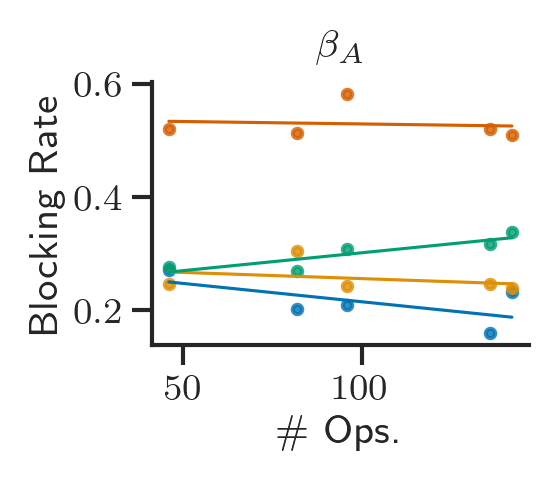

Plotting dist $\beta_{B}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


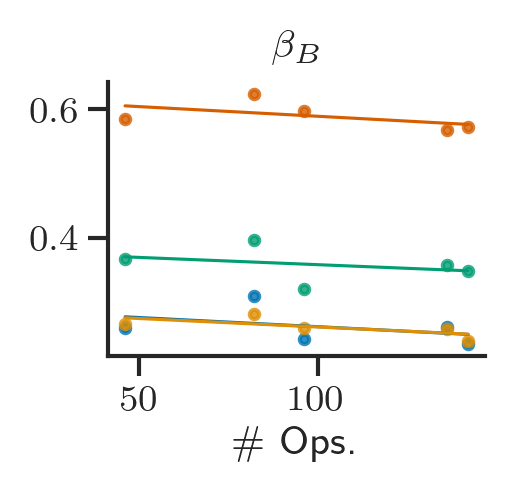

Plotting dist $\beta_{C}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


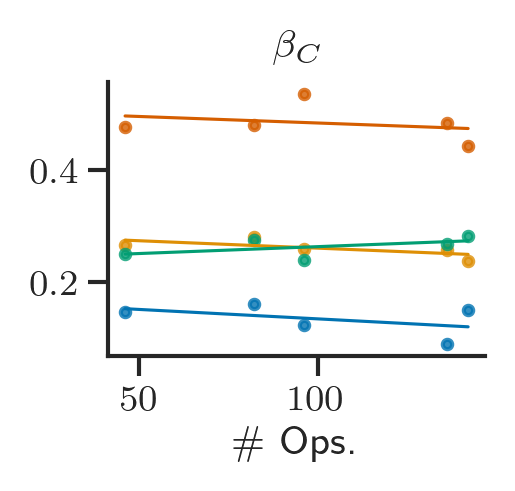

Plotting dist $\beta_{D}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


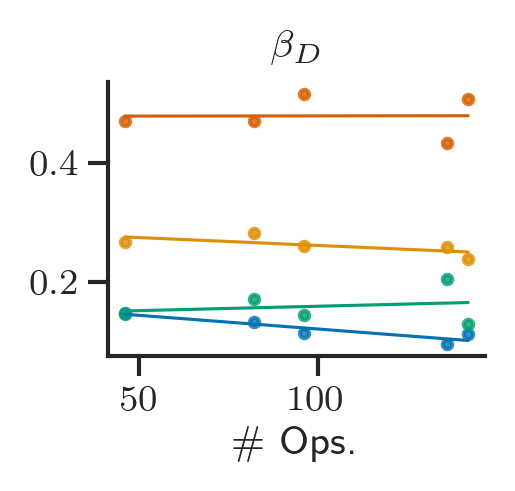

Plotting dist $\beta_{A}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


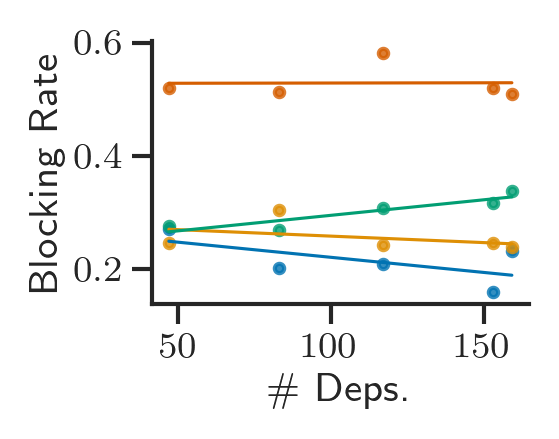

Plotting dist $\beta_{B}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


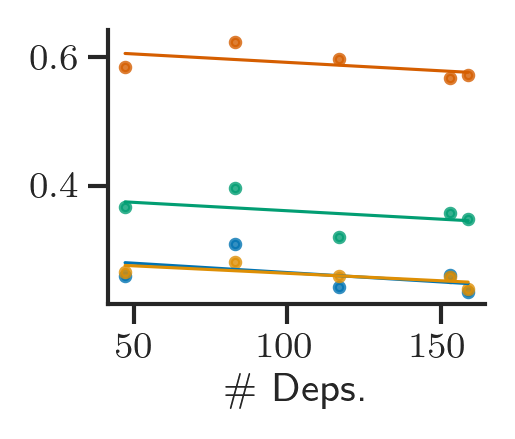

Plotting dist $\beta_{C}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


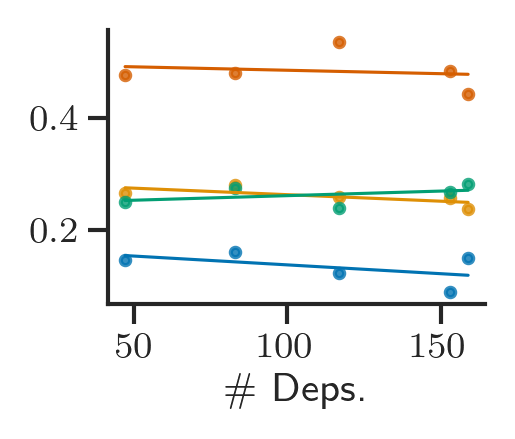

Plotting dist $\beta_{D}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


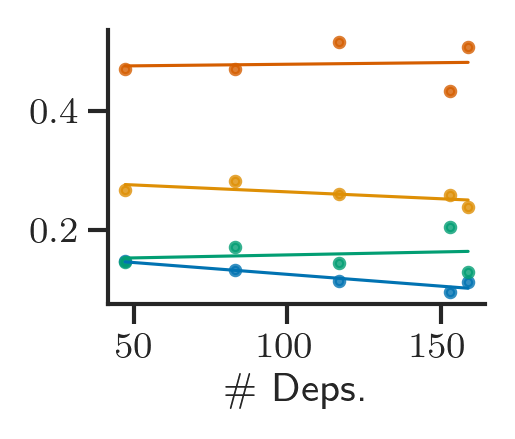

Plotting dist $\beta_{A}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


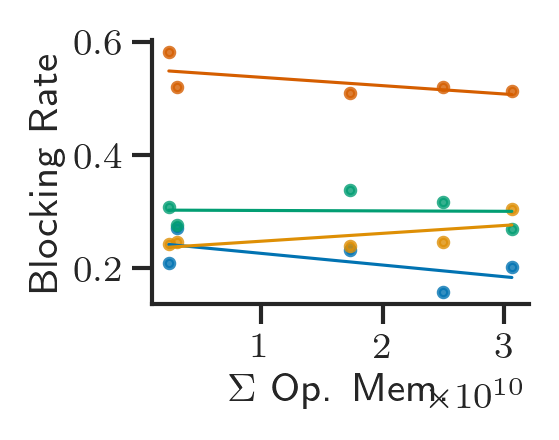

Plotting dist $\beta_{B}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


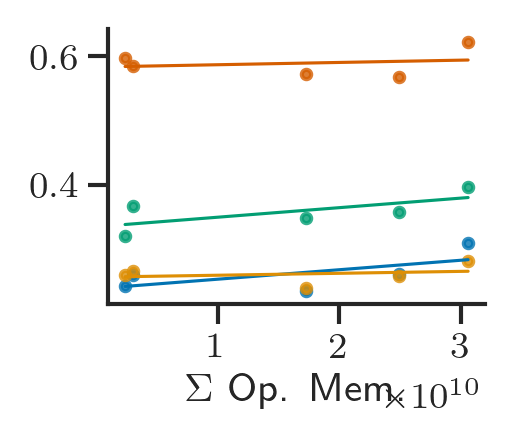

Plotting dist $\beta_{C}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


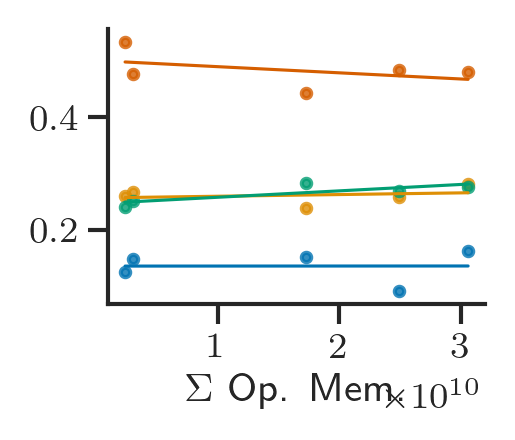

Plotting dist $\beta_{D}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


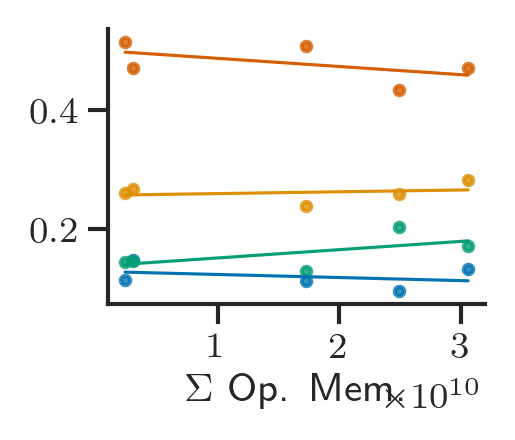

Plotting dist $\beta_{A}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


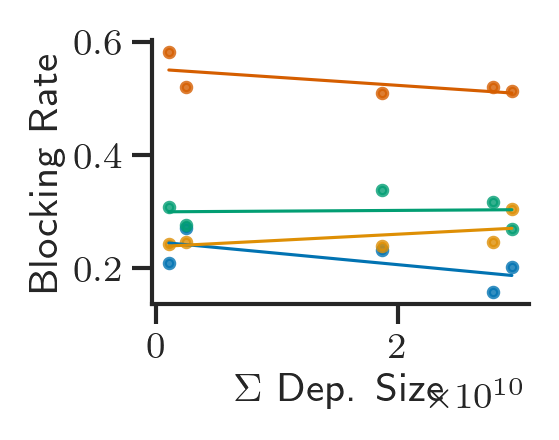

Plotting dist $\beta_{B}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


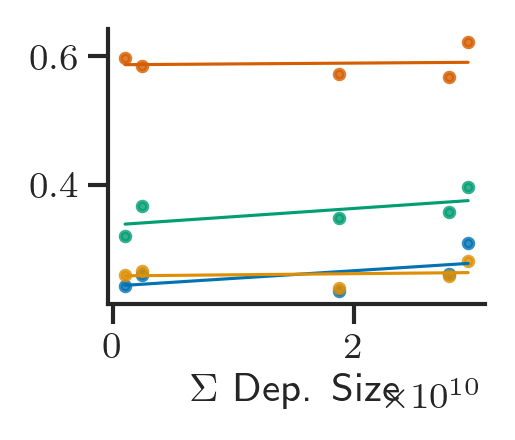

Plotting dist $\beta_{C}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


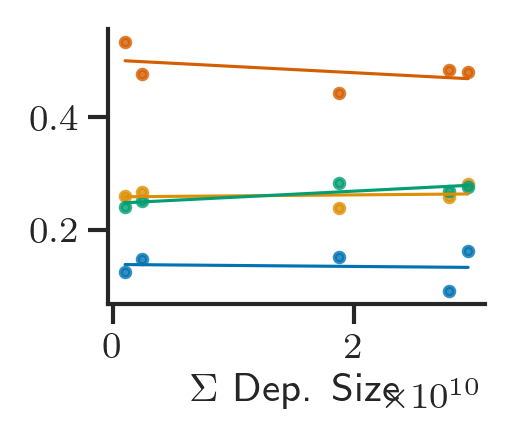

Plotting dist $\beta_{D}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


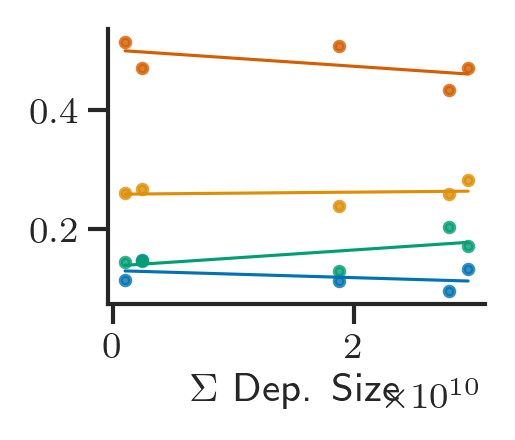

Plotting dist $\beta_{A}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


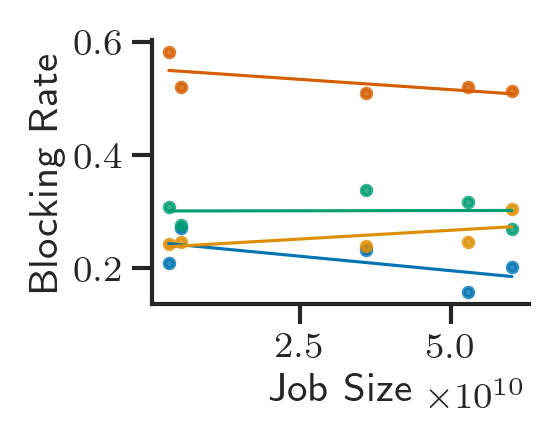

Plotting dist $\beta_{B}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


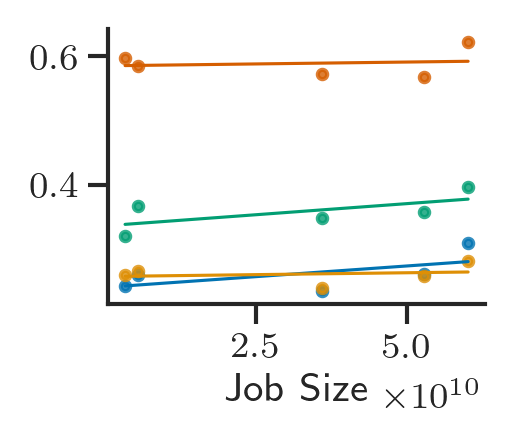

Plotting dist $\beta_{C}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


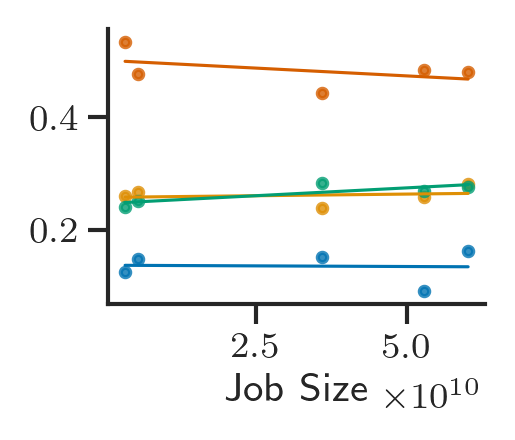

Plotting dist $\beta_{D}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


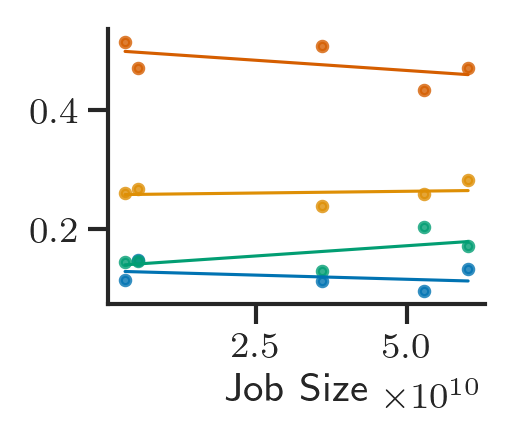

Plotting dist $\beta_{A}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


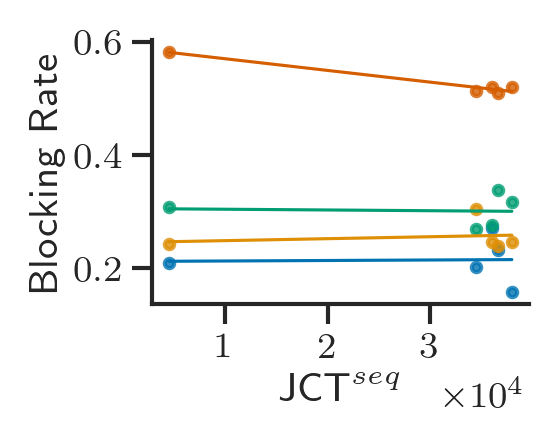

Plotting dist $\beta_{B}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


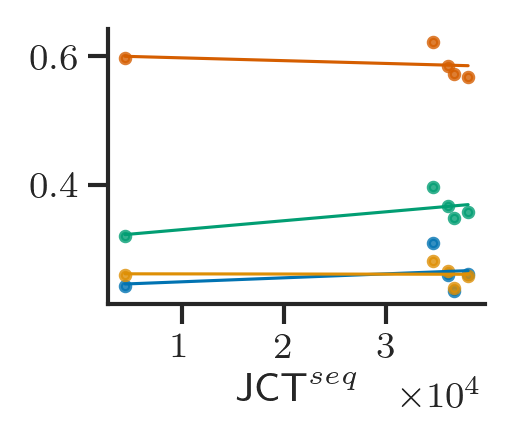

Plotting dist $\beta_{C}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


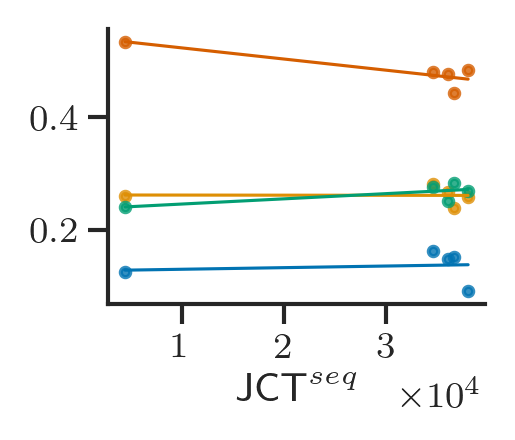

Plotting dist $\beta_{D}$
hue_order: ['PAC-ML (Ours)', 'Para$_{max}$', 'Para$_{min}$', 'Random']
{'PAC-ML (Ours)': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'Para$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'Para$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}


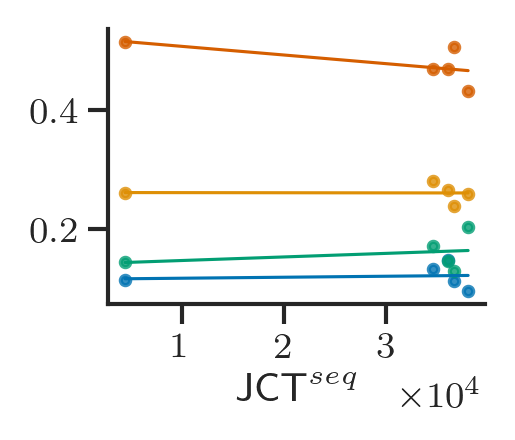

In [87]:
grouped_df = agent_per_job_metric_blocking_rate_df.groupby(['$\\beta_{X}$'])

for metric in metrics:
    for dist, df in grouped_df:
        # scatterplot(df=copy.deepcopy(agent_per_job_metric_blocking_rate_df), metric=metric+'_blocking_rate', xaxis=metric, add_line_of_best_fit=False)
        print(f'Plotting dist {dist}')
        
        if dist == '$\\beta_{A}$':
            # LHS column -> show y-axis
            show_yaxis_title = True
        else:
            show_yaxis_title = False
        if metric == 'original_demand_num_nodes':
            # top row -> show title
            title = dist
        else:
            title = None
        if 'num_nodes' in metric or 'num_edges' in metric:
            xaxis_label_style = 'plain'
        else:
            xaxis_label_style = 'sci'
        
        scatterplot(df=copy.deepcopy(df),
                    metric=metric+'_blocking_rate', 
                    xaxis=metric, 
                    show_yaxis_title=show_yaxis_title,
                    xaxis_label_style=xaxis_label_style,
                    add_line_of_best_fit=True, 
                    title=title, 
                    ylabel='Blocking Rate',
                    height=1.6,
                    aspect=1.25,
                    line_kws={'linewidth': 0.75},
                    scatter_kws={'s': 5},
                    facet_kws={'sharex': True, 'sharey': True, 'margin_titles': True},
                   )

### TODO
- Try to make about markers styles by Agent as in other plots
- Plot JCT speed-up vs. above metrics for completed jobs and/or max partitions per op -> see which jobs are being parallelised more

# Per-Job Partition Degree Metrics

In [65]:
# use completed dataframe to create a partition degree dataframe for each metric of interest

metrics = [
            'original_demand_num_nodes',
            'original_demand_num_edges',
    
            'original_demand_total_operation_memory_cost',
            'original_demand_total_dependency_size',
    
            'job_sequential_completion_time',
    
        ]


grouped_df = agent_episode_completion_stats_df.groupby(['$\\beta_{X}$'])

# for metric in metrics:
#     for dist, df in grouped_df:
#         # scatterplot(df=copy.deepcopy(agent_per_job_metric_blocking_rate_df), metric=metric+'_blocking_rate', xaxis=metric, add_line_of_best_fit=False)
#         print(f'Plotting dist {dist}')
#         histplot(df=copy.deepcopy(df),
#                     metric='jobs_completed_max_partitions_per_op', 
#                     title=dist,
#                     # xaxis=metric,
#                     # add_line_of_best_fit=True, 
#                     # title=dist, 
#                     # ylabel='Blocking Rate',
#                     # height=2,
#                     # aspect=1.5,
#                     # line_kws={'linewidth': 0.75},
#                     # scatter_kws={'s': 5},
#                     # facet_kws={'sharex': True, 'sharey': True, 'margin_titles': True},
#                    )


# round job sequential completion time to remove floating point differences so can easily group on per-job basis
agent_episode_completion_stats_df['jobs_completed_job_sequential_completion_time'] = np.around(agent_episode_completion_stats_df['jobs_completed_job_sequential_completion_time'], decimals=7)

# group dataframes by agent, beta distribution, and partition degree
agent_completion_grouped_df = agent_episode_completion_stats_df.groupby(['Agent', '$\\beta_{X}$'])

# count number of times each per-job metric occurs in completed data frame
agent_to_dist_to_metric_to_value_to_partition_degree = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0))))
for agent in agent_to_beta_dist_to_run_path.keys():
    for metric in metrics:    
        # count metric occurrances for each unique partition degree in completed df for each agent
        
        # gather unique partition degrees for for each unique value of this metric
        for keys, agent_df in agent_completion_grouped_df:
            _agent, dist = keys
            if _agent == agent:
                print(f'\tAgent: {agent} | Dist: {dist}')
                # get mean partition degree for each unique metric value
                agent_df_grouped_by_metric_values = agent_df.groupby(['jobs_completed_' + metric])
                for metric_value, metric_df in agent_df_grouped_by_metric_values:
                    # partition_degree = np.mean(metric_df['jobs_completed_max_partitions_per_op'])
                    partition_degree = np.mean(metric_df['job_completion_time_speedup'])
                    print(f'Metric {metric} | Value: {metric_value} | Partition degree: {partition_degree}')
                    agent_to_dist_to_metric_to_value_to_partition_degree[agent][dist][metric][metric_value] = partition_degree
                    
                    
        
        # for keys, agent_df in agent_completion_grouped_df:
        #     _agent, dist = keys
        #     if _agent == agent:
        #         print(f'\tAgent: {agent} | Dist: {dist}')
        #         metric_values, metric_counts = np.unique(agent_df['jobs_completed_' + metric], return_counts=True)
        #         for metric_value, metric_count in zip(metric_values, metric_counts):
        #             print(f'Metric {metric} | Value: {metric_value} | Count: {metric_count}')
        #             agent_to_dist_to_metric_to_value_to_partition_degree[agent][dist][metric][metric_value] = metric_count
            
            
raise Exception()

    
for key, val in agent_per_job_metric_blocking_rate_df.items():
    print(f'key {key} -> {len(val)} vals')
agent_per_job_metric_blocking_rate_df = pd.DataFrame(agent_per_job_metric_blocking_rate_df)
display(agent_per_job_metric_blocking_rate_df)

	Agent: PAC-ML (Ours) | Dist: $\beta_{A}$
Metric original_demand_num_nodes | Value: 46 | Partition degree: 3.9997041839508327
Metric original_demand_num_nodes | Value: 82 | Partition degree: 3.9965826993658413
Metric original_demand_num_nodes | Value: 96 | Partition degree: 3.999197805771959
Metric original_demand_num_nodes | Value: 136 | Partition degree: 3.998614429900764
Metric original_demand_num_nodes | Value: 142 | Partition degree: 3.99871096851608
	Agent: PAC-ML (Ours) | Dist: $\beta_{B}$
Metric original_demand_num_nodes | Value: 46 | Partition degree: 15.993354815041847
Metric original_demand_num_nodes | Value: 82 | Partition degree: 15.923243637973469
Metric original_demand_num_nodes | Value: 96 | Partition degree: 14.497270292504368
Metric original_demand_num_nodes | Value: 136 | Partition degree: 15.971835356371763
Metric original_demand_num_nodes | Value: 142 | Partition degree: 15.971796038750488
	Agent: PAC-ML (Ours) | Dist: $\beta_{C}$
Metric original_demand_num_nodes |

Exception: 

In [13]:
val_range = [-10, 0]

num_vals = abs(max(val_range) - min(val_range)) + 1
print(f'\tval_range: {val_range} -> num_vals: {num_vals}')
for idx, val in enumerate(range(min(val_range), max(val_range)+1)):
    print(f'val {val} -> idx {idx}')

val = 0 # should have val_idx = 298

val_idx = (num_vals - 1) - (max(val_range) - val)
print(f'\tval: {val} -> val_idx: {val_idx}')

	val_range: [-10, 0] -> num_vals: 11
val -10 -> idx 0
val -9 -> idx 1
val -8 -> idx 2
val -7 -> idx 3
val -6 -> idx 4
val -5 -> idx 5
val -4 -> idx 6
val -3 -> idx 7
val -2 -> idx 8
val -1 -> idx 9
val 0 -> idx 10
	val: 0 -> val_idx: 10
